# Bayesian methods for hackers
![](https://upload.wikimedia.org/wikipedia/commons/d/d4/Thomas_Bayes.gif)

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
# from tqdm import tqdm

# Scipy
from scipy import stats

# Probabilistic programming
import tensorflow as tf
import edward as ed
import pyro

In [2]:
plt.style.use('ggplot')
plt.rcParams['font.serif'] = 'Ubuntu'
plt.rcParams['font.monospace'] = 'Ubuntu Mono'
plt.rcParams['font.size'] = 10
plt.rcParams['axes.labelsize'] = 10
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['grid.color'] = "#d4d4d4"
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
plt.rcParams['legend.fontsize'] = 10
plt.rcParams['figure.titlesize'] = 10
plt.rcParams['lines.linewidth'] = 2

In [3]:
colors = ['#348ABD']

***
# Introduction

## Introduction

### Scipy and numpy for probabilities and statistics

##### Random Variables sampled from Bernoulli distribution

In [12]:
stats.bernoulli.rvs(0.5, size=10)

array([1, 1, 1, 1, 0, 0, 0, 0, 1, 1])

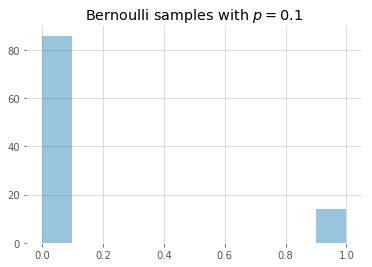

In [57]:
plt.title("Bernoulli samples with $p=0.1$")
plt.hist(stats.bernoulli.rvs(0.1, size=100),color = colors[0],alpha = 0.5)
plt.show()

##### Observing Bernoulli samples with a conjugate Binomial prior

In [45]:
def coin_toss(size = 10,p = 0.5):
    data = stats.bernoulli.rvs(p, size=size)
    x = np.linspace(0, 1, 100)
    heads = np.sum(data)
    tails = size - heads
    print("{} heads and {} tails for {} throws".format(heads,tails,size))
    y = stats.beta.pdf(x,1+heads,1+tails)
    plt.title("{} throws, $p={}$".format(size,p))
    plt.plot(x,y,color=colors[0])
    plt.fill_between(x, 0, y, color=colors[0], alpha=0.4)
    plt.vlines(p, 0, np.max(y), color="k", linestyles="--", lw=1)
    plt.show()

7 heads and 3 tails for 10 throws


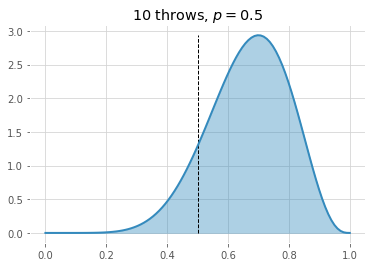

In [53]:
coin_toss()

60 heads and 40 tails for 100 throws


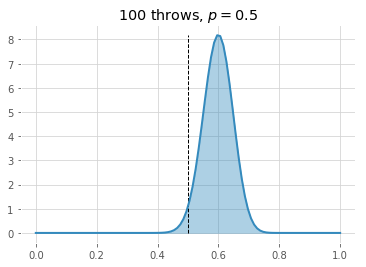

In [54]:
coin_toss(size = 100)

527 heads and 473 tails for 1000 throws


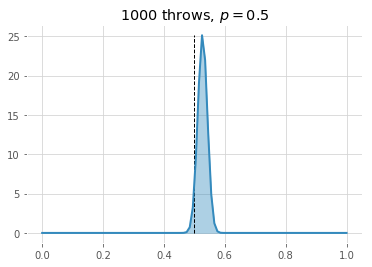

In [55]:
coin_toss(size = 1000)

1 heads and 9 tails for 10 throws


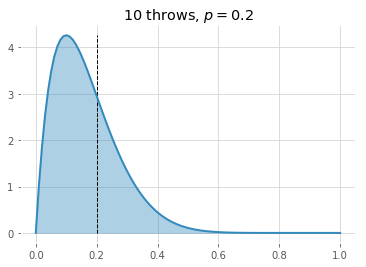

In [56]:
coin_toss(size = 10,p = 0.2)

## Distributions

### Poisson distribution
https://en.wikipedia.org/wiki/Poisson_distribution
> **Discrete probability distribution** that expresses the probability of a given number of events occurring in a fixed interval of time or space if these events occur with a known constant rate and independently of the time since the last event. The Poisson distribution can also be used for the number of events in other specified intervals such as distance, area or volume.

$$P(Z = k) =\frac{ \lambda^k e^{-\lambda} }{k!}, \; \; k=0,1,2, \dots $$

### Exponential distribution
$$f_Z(z | \lambda) = \lambda e^{-\lambda z }, \;\; z\ge 0$$

***
# The Bayesian coin toss

## Using Edward

In [6]:
from edward.models import Bernoulli,Beta,Empirical,Normal,Poisson,Uniform

### Via Metropolis Hastings
https://github.com/blei-lab/edward/blob/master/examples/beta_bernoulli.py

In [6]:
p_heads = 0.2
size = 50

x_data = stats.bernoulli.rvs(p_heads,size =  size)
n_heads,n_tails = (x_data == 1).sum(),(x_data == 0).sum()
print(n_heads,n_tails)
x_data

11 39


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0,
       0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0])

In [7]:
# MODEL
p = Beta(1.0, 1.0)
x = Bernoulli(probs=p, sample_shape=size)

# INFERENCE
qp = Empirical(params=tf.Variable(tf.zeros([10000]) + 0.5))

proposal_p = Beta(np.float32(1),np.float32(1))

In [8]:
inference = ed.MetropolisHastings({p: qp}, {p: proposal_p}, data={x: x_data})

In [9]:
inference.run()

10000/10000 [100%] ██████████████████████████████ Elapsed: 15s | Acceptance Rate: 0.181


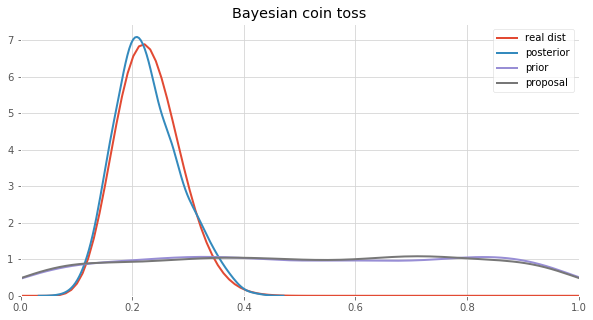

In [10]:
plt.figure(figsize = (10,5))
real_dist = stats.beta.pdf(np.linspace(0,1,100),1+n_heads,1+n_tails)
plt.plot(np.linspace(0,1,100),real_dist,label = "real dist")
sns.distplot(qp.sample(1000).eval(),label = "posterior",hist = False)
sns.distplot(p.sample(1000).eval(),label = "prior",hist = False)
sns.distplot(proposal_p.sample(1000).eval(),label = "proposal",hist = False)
plt.legend()
plt.title("Bayesian coin toss")
plt.xlim(0,1)
plt.show()

### Via Variational Inference

In [5]:
x_data = stats.bernoulli.rvs(0.2,size =  10)
x_data

array([0, 0, 0, 0, 0, 1, 0, 0, 0, 0])

In [6]:
p = Uniform(low = 0.0,high = 1.0)
x = Bernoulli(probs = p,sample_shape = 10)

In [7]:
qp = Beta(1.0,1.0)

In [18]:
inference = ed.KLqp({p : qp}, data={x:x_data})

In [19]:
inference.run(n_samples = 10,n_iter = 500)

ValueError: No variables provided.

In [ ]:
from tqdm import tqdm

sess = ed.get_session()
init = tf.global_variables_initializer()
init.run()
learning_curve = []
for _ in tqdm(range(inference.n_iter)):
    info_dict = inference.update()
    learning_curve.append(info_dict['loss'])
plt.semilogy(learning_curve)
plt.show()

### Via Monte Carlo Sampling

In [40]:
x_data = stats.bernoulli.rvs(0.2,size =  10)
x_data

array([0, 0, 0, 0, 0, 1, 0, 0, 0, 0])

In [52]:
p = Uniform(low = 0.0,high = 1.0)
# p = Normal(loc = 0.5,scale = 0.1)

x = Bernoulli(probs = p,sample_shape = 10)

In [53]:
T = 10000
qp = Empirical(params=tf.Variable(tf.zeros([T,])+0.5))

In [54]:
inference = ed.HMC(latent_vars = {p : qp}, data={x:x_data})

In [55]:
inference.initialize(step_size = 0.25)

100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [00:14<00:00, 706.33it/s]


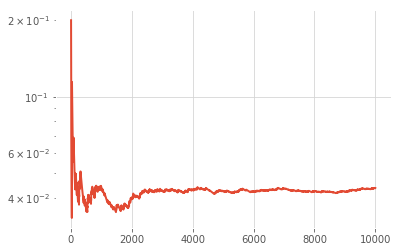

In [56]:
from tqdm import tqdm

sess = ed.get_session()
init = tf.global_variables_initializer()
init.run()
learning_curve = []
for _ in tqdm(range(inference.n_iter)):
    info_dict = inference.update()
    learning_curve.append(info_dict['accept_rate'])
plt.semilogy(learning_curve)
plt.show()

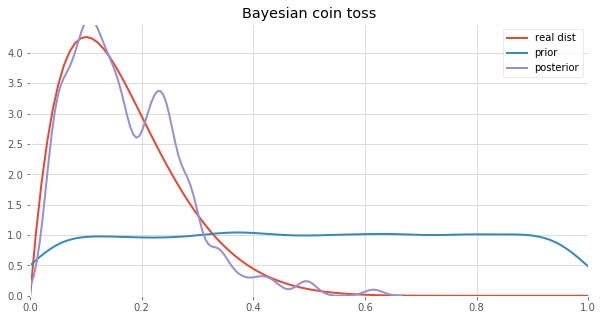

In [59]:
plt.figure(figsize = (10,5))
real_dist = stats.beta.pdf(np.linspace(0,1,100),1+1,1+9)
plt.plot(np.linspace(0,1,100),real_dist,label = "real dist")
sns.distplot(p.sample(10000).eval(),bins = 20,label = "prior",hist = False)
sns.distplot(qp.sample(10000).eval(),bins = 20,label = "posterior",hist = False)
plt.legend()
plt.title("Bayesian coin toss")
plt.xlim(0,1)
plt.show()

***
# The SMS behavior problem

## Creating the dataset

##### Switching point

In [59]:
tau = np.random.randint(0,80)
tau

48

##### Draw $\lambda_1$ and $\lambda_2$ from exponential distribution

In [62]:
alpha = 1/20.

In [74]:
lambda1,lambda2 = np.random.exponential(scale = 1/alpha,size = 2)
print(lambda1,lambda2)

41.3107591263 17.5161468002


##### Sample from Poisson distribution the number of texts sent

In [75]:
data1 = stats.poisson.rvs(mu = lambda1,size = tau)
data2 = stats.poisson.rvs(mu = lambda2,size = 80 - tau)
data1

array([43, 36, 43, 50, 40, 35, 48, 51, 42, 38, 41, 39, 40, 45, 51, 55, 42,
       43, 45, 54, 46, 39, 39, 48, 40, 36, 41, 44, 33, 50, 27, 28, 49, 38,
       40, 45, 61, 41, 33, 49, 48, 38, 43, 42, 43, 44, 48, 37])

In [78]:
data = np.hstack([data1,data2])

##### Plot the dataset

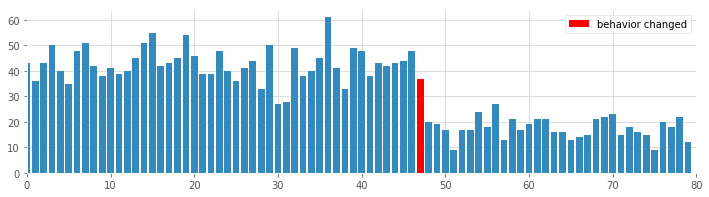

In [84]:
plt.figure(figsize=(12,3))
plt.bar(np.arange(80),data,color = colors[0])
plt.bar(tau-1,data[tau-1],color = "r",label = "behavior changed")
plt.legend()
plt.xlim(0,80)
plt.show()

## Solving the problem

### Solving the problem with Edward

In [87]:
sess = tf.Session()

In [92]:
alpha_observed = 1.0 / data.mean()
alpha_observed

0.030581039755351678

In [94]:
alpha_observed = tf.Variable(alpha_observed, name="alpha", dtype=tf.float32)
alpha_observed

<tf.Variable 'alpha_1:0' shape=() dtype=float32_ref>

In [95]:
from edward import models

In [146]:
lambda1 = models.Exponential(alpha_observed)
lambda2 = models.Exponential(alpha_observed)
tau = models.Uniform(low = 0.0,high = 80.0)
idx = np.arange(80)

In [147]:
lambda_ = tf.where(tau>=idx,
                   tf.ones(shape=[80,],dtype=tf.float32)*lambda1,
                   tf.ones(shape=[80,],dtype=tf.float32)*lambda2)

In [148]:
z = models.Poisson(lambda_,value=tf.Variable(tf.ones(80)))

In [149]:
T = 100  # number of posterior samples
qlambda1 =  models.Empirical(params=tf.Variable(tf.zeros([T,])))
qlambda2 =  models.Empirical(params=tf.Variable(tf.zeros([T,])))

In [150]:
qtau = models.Empirical(params=tf.Variable(tf.zeros([T,])))

In [151]:
qz = models.Empirical(params=tf.Variable(tf.random_normal([80,])))

In [152]:
inference = ed.HMC({lambda1:qlambda1,lambda2:qlambda2,tau:qtau},data={z:data})
inference.run()

100/100 [100%] ██████████████████████████████ ETA: 1730s | Acceptance Rate: na ETA: 857s | Acceptance Rate: 0.0 ETA: 566s | Acceptance Rate: 0.0 ETA: 421s | Acceptance Rate: 0.0 ETA: 334s | Acceptance Rate: 0.0 ETA: 277s | Acceptance Rate: 0.0 ETA: 235s | Acceptance Rate: 0.1 ETA: 203s | Acceptance Rate: 0.1 ETA: 179s | Acceptance Rate: 0.1 ETA: 159s | Acceptance Rate: 0.1 ETA: 130s | Acceptance Rate: 0.2 ETA: 119s | Acceptance Rate: 0.2 ETA: 109s | Acceptance Rate: 0.3 ETA: 101s | Acceptance Rate: 0.3 ETA: 93s | Acceptance Rate: 0.333 ETA: 87s | Acceptance Rate: 0.37 ETA: 81s | Acceptance Rate: 0.41 ETA: 76s | Acceptance Rate: 0.44 ETA: 71s | Acceptance Rate: 0.47 ETA: 67s | Acceptance Rate: 0.45 ETA: 63s | Acceptance Rate: 0.47 ETA: 60s | Acceptance Rate: 0.45 ETA: 57s | Acceptance Rate: 0.43 ETA: 54s | Acceptance Rate: 0.45 ETA: 51s | Acceptance Rate: 0.44 ETA: 48s | Acceptance Rate: 0.42 ETA: 46s | Acceptance Rate: 0.44 ETA: 44s | Acceptance Rate: 0.46 ETA: 42s | Acceptance Rate: 0

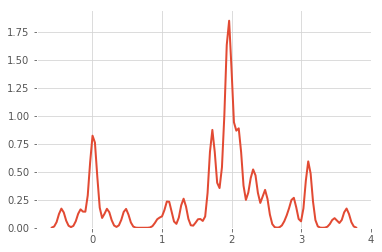

In [154]:
# sns.distplot(lambda2.sample(1000).eval(),kde = True,hist = False)
sns.distplot(qlambda2.sample(1000000).eval(),kde = True,hist = False)
plt.show()

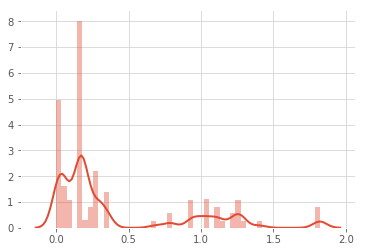

In [155]:
# sns.distplot(lambda2.sample(1000).eval(),kde = True,hist = False)
sns.distplot(qtau.sample(100000).eval(),kde = True,hist = True)
plt.show()

### Solving the problem with Pyro

## With other artificial datasets